In [1]:
!pip install statsmodels

In [2]:
import math
import random
import re

import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats as st
from scipy.stats import norm

# Огляд scipy.stats

In [3]:
rv = norm()

In [4]:
rv

In [ ]:
# dir(rv)

In [5]:
st.rv_continuous

scipy.stats._distn_infrastructure.rv_continuous

In [6]:
dist_continu = [d for d in dir(st) if
                isinstance(getattr(st, d), st.rv_continuous)]
dist_discrete = [d for d in dir(st) if
                 isinstance(getattr(st, d), st.rv_discrete)]
print('Кількість неперервних розподілів: %d' % len(dist_continu))
print('Кількість дискретних розподілів:   %d' % len(dist_discrete))

Кількість неперервних розподілів: 107
Кількість дискретних розподілів:   19


In [7]:
norm.cdf(0)

0.5

Можемо вивести для декількох точок.

In [8]:
norm.cdf([-1., 0, 1])

array([0.15865525, 0.5       , 0.84134475])

In [9]:
norm.cdf(2, 0, 1)

0.9772498680518208

Якщо хочемо отримати CDF і PDF певного розподілу:

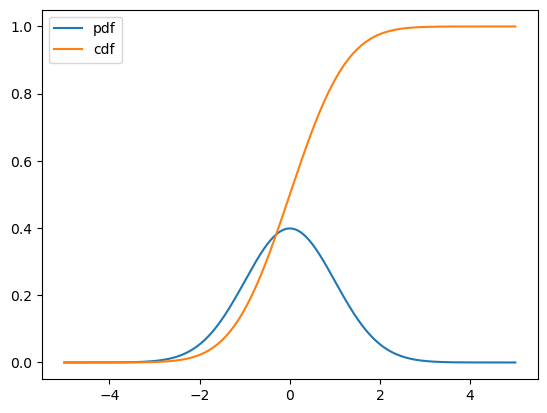

In [10]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

y_pdf = norm.pdf(x, mu, sigma)  # pdf нормального розподілу
y_cdf = norm.cdf(x, mu, sigma)  # cdf нормального розподілу

plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend();

Можемо дослідити, як параметри розподілу впливають на його вигляд:

In [11]:
def plot_normal(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    x = x_range
    if cdf:
        y = norm.cdf(x, mu, sigma)
    else:
        y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)

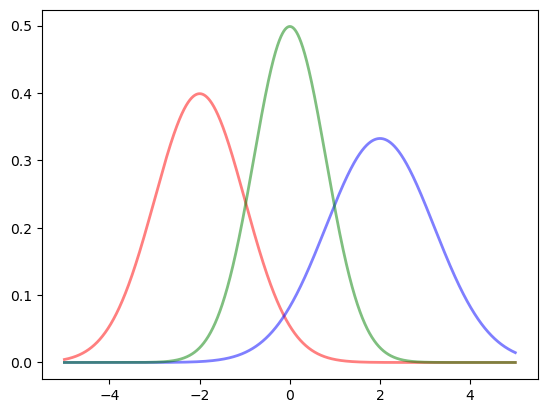

In [12]:
plot_normal(x, -2, 1, color='red', lw=2, ls='-', alpha=0.5)
plot_normal(x, 2, 1.2, color='blue', lw=2, ls='-', alpha=0.5)
plot_normal(x, 0, 0.8, color='green', lw=2, ls='-', alpha=0.5);

Створимо та проведемо дослідження вибірки із заданого розподілу:

In [13]:
from scipy.stats import beta

# для відтворюваності
np.random.seed(seed=233423)

a, b = 2, 6

x = beta.rvs(a, b, size=1000)

In [14]:
x.mean()

0.24882674925049725

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(x, density=True, alpha=0.2)
plt.show()

Виведемо описові статистики розподілу:

In [15]:
m = beta.mean(a,b)
v = beta.var(a,b)
shp_a = beta.a
shp_b = beta.b
median = beta.median(a,b)

rv_stats = {"mean": m, "var": v, "shape a": shp_a, "shape b": shp_b, "median": median}
_ = [print(k,":",f'{v:.3f}') for k,v in rv_stats.items()]

mean : 0.250
var : 0.021
shape a : 0.000
shape b : 1.000
median : 0.228


Перші 4 моменти (про [моменти](https://www.analyticsvidhya.com/blog/2022/01/moments-a-must-known-statistical-concept-for-data-science/#:~:text=%E2%80%93%20Standardized%20Moments-,What%20is%20the%20Moment%20in%20Statistics%3F,as%20the%20X's%20expected%20values.)) :

In [16]:
moments_values = beta.stats(a,b, moments="mvsk")

moments_names = ["mean", "var", "skew", "kurt"]
moments = dict(zip(moments_names, moments_values))
_ = [print(k,":",f'{v:.3f}') for k,v in moments.items()]

mean : 0.250
var : 0.021
skew : 0.693
kurt : 0.109


# Узгодження розподілу з даними

Припустимо, ми хочемо зʼясувати, за яким законом розподілу розподілені наші дані. Для цього можемо спробувати зафітити кілька різних розподілів і подивитися, який найкраще описує наші дані.

In [17]:
def doane_formula(data):
    """
    Формула для пошуку оптимальної кількості бінів для візуалізації та аналізу даних:
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def plot_histogram(data, results, n):
    # N перших розподілів у ранжуванні
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    # Гістограма даних
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')
    
    # Розподіл
    for distribution, result in N_DISTRIBUTIONS.items():
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        dist_name = re.search(r'_continuous_distns\.(.*?) object', str(distribution)).group(1)
        plt.plot(x_plot, y_plot, label=dist_name + ": " + str(sse)[0:6], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ALL_DISTRIBUTIONS = [d for d in dir(st) if
                isinstance(getattr(st, d), st.rv_continuous)]
    
    MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm, 
                        st.uniform, st.johnsonsb, st.gennorm,
                        st.gausshyper]

    # Шукаємо оптимальну кількість бінів у гістограмі за формулою Доані
    num_bins = doane_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        # Отримуємо параметри розподілу
        params = distribution.fit(data)
        
        # Виділяємо потрібні нам частини параметрів
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
    
        # Розраховуємо підігнаний PDF і похибку підгонки розподілу
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        # Рахуємо суму квадратів помилки
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        # Збираємо результати
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

Набір даних, який будемо досліджувати в цьому завданні, містить океанографічні та надземні метеорологічні дані, отримані з низки буїв, розташованих по всій екваторіальній частині Тихого океану:
https://archive.ics.uci.edu/ml/datasets/El+Nino  

Дані зібрано за кілька років, колонки - це місяці. Тому перед аналізом нам треба трансформувати набір даних.

In [18]:
df = sm.datasets.elnino.load_pandas().data.set_index('YEAR')

In [19]:
df

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73


In [21]:
data = pd.Series(df.values.ravel()) # df.ravel() - вертає плоский масив даних

In [22]:
results = fit_data(data)

In [23]:
st.beta

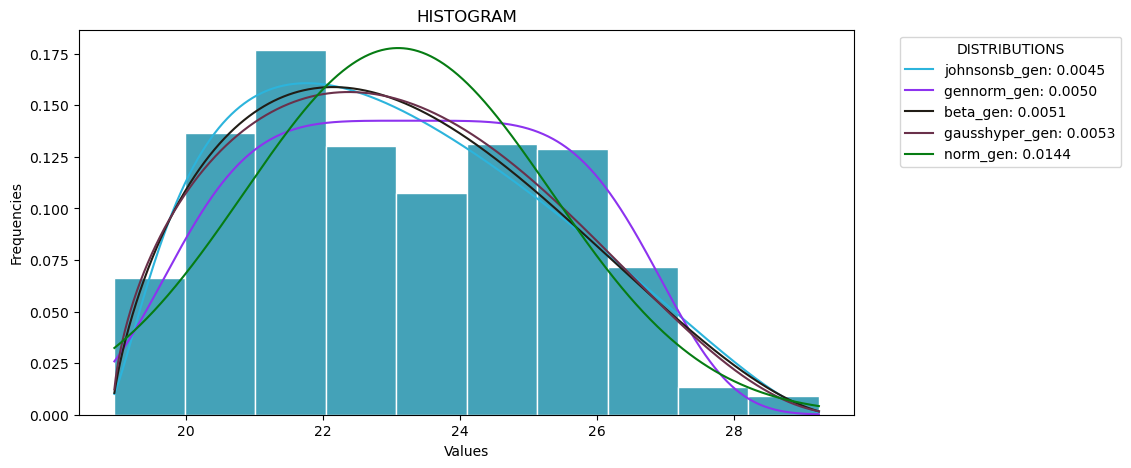

In [24]:
plot_histogram(data, results, 5)

# Z-test

In [32]:
from statsmodels.stats.weightstats import ztest  

## На одній вибірці

Згенеруємо випадковий масив із 50 чисел, що мають середнє значення 110 і стандартне відхилення 15, аналогічно до даних IQ, які ми припускаємо в задачі.

In [26]:
mean_iq = 110
sd_iq = 15 / math.sqrt(50)
alpha = 0.05
null_mean = 100

In [27]:
# генеруємо дані
data = np.random.randn(50)*15 + mean_iq

In [28]:
sd_iq

2.1213203435596424

In [29]:
print('mean=%.2f stdv=%.2f' % (np.mean(data), np.std(data)))
  

mean=109.28 stdv=12.90


In [30]:
data

array([101.98832215, 116.37222237, 115.39213549, 122.5666613 ,
       104.16216359, 114.85230846, 107.64974823, 117.81983884,
       105.85103011,  68.33873229,  96.95971846, 109.58129048,
       112.42406452, 126.1525581 ,  93.89665105,  84.04256154,
       106.49134085, 104.02658116, 139.5350113 , 129.06124673,
        96.02310886,  84.04793057, 134.18102155, 111.93382851,
       132.12305991,  99.26056604, 120.19944999,  98.99527591,
       109.81909476, 108.666749  , 108.51571809, 108.65378687,
        96.7035517 , 113.06508848, 120.99995771, 109.5229625 ,
       122.10874311, 111.93250173,  95.88649668,  96.51400173,
       112.57262376,  95.7557653 , 115.44710945, 108.60740075,
       114.50725177, 119.4490866 , 109.23178724, 113.17487388,
       105.58763939, 113.2295283 ])

Тепер проводимо тест. У цій функції ми передали дані, у параметрі значення ми передали середнє значення в нульовій гіпотезі, в альтернативній гіпотезі ми перевіряємо, чи більше середнє значення

In [33]:
ztest_Score, p_value = ztest(data, value = null_mean, alternative='larger')

In [34]:
ztest_Score, p_value

(5.034569110259027, 2.394624371752102e-07)

Функція виводить p_value і z-score, що відповідають цьому значенню, ми порівнюємо p-значення з альфа, якщо воно більше альфа, то ми не приймаємо нульову гіпотезу, інакше ми її відхиляємо.

In [ ]:
if(p_value <  alpha):
    print("Відхилити Н0.")
else:
    print("Н0 не може бути відхилена.")

## На двох вибірках

Порівняємо рівні IQ у двох різних містах.

In [ ]:
cityA = [82, 84, 85, 89, 91, 91, 92, 94, 99, 99,
         105, 109, 109, 109, 110, 112, 112, 113, 114, 114]

cityB = [90, 91, 91, 91, 95, 95, 99, 99, 108, 109,
         109, 114, 115, 116, 117, 117, 128, 129, 130, 133]

In [ ]:
np.mean(cityA), np.mean(cityB)

Виконуємо тест.

Важливий параметр методу ztest:
- value : float  
    In the one sample case, value is the mean of x1 under the Null
    hypothesis.
    In the two sample case, value is the difference between mean of x1 and
    mean of x2 under the Null hypothesis. The test statistic is
    `x1_mean - x2_mean - value`.
    
Метод z-test вертає

- tstat : float,
    test statistic
- pvalue : float,
    pvalue of the t-test

In [ ]:
ztest(cityA, cityB, value=0)

Статистика для двох вибірок z-критерію становить -1.9953, а відповідне p-value дорівнює 0.0460.

Оскільки p-value < 0.05, у нас є достатньо доказів, щоб відкинути нульову гіпотезу. Іншими словами, середній рівень IQ значно різниться між двома містами.